In [2]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
# import aesara as asr
from aesara import shared
import pytensor

# az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ

['005930',
 '005935',
 '000660',
 '006400',
 '006405',
 '051910',
 '051915',
 '005380',
 '005385',
 '035420',
 '068270',
 '000270',
 '035720',
 '105560',
 '005490',
 '055550',
 '207940',
 '012330',
 '373220',
 '028260',
 '086790',
 '033780',
 '066570',
 '066575',
 '096770',
 '316140',
 '017670',
 '034730',
 '003550',
 '030200',
 '009150',
 '259960',
 '036570',
 '323410',
 '000810',
 '009830',
 '015760',
 '032830',
 '051900',
 '010130',
 '011200',
 '003490',
 '034020',
 '003670',
 '011070',
 '018260',
 '402340',
 '028050',
 '009540',
 '010950',
 '010140',
 '352820',
 '047810',
 '097950',
 '090430',
 '034220',
 '021240',
 '000100',
 '035250',
 '086280',
 '032640',
 '251270',
 '000720',
 '011170',
 '267250',
 '004020',
 '024110',
 '161390',
 '377300',
 '010620',
 '005830',
 '011780',
 '008770',
 '383220',
 '271560',
 '006800',
 '329180',
 '071050',
 '012450',
 '018880',
 '078930',
 '016360',
 '011790',
 '001450',
 '139480',
 '010060',
 '128940',
 '138930',
 '004170',
 '030000',
 '302440',

In [260]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [261]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); p.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-05,63900,53800,84600,778000,345500,732000,327500,186700,94900,199200,...,171200,79900,8930,15410,32860,13320,14745,13225,11830,111955
2023-04-06,62300,53100,83800,745000,338000,716000,318000,185100,94200,191900,...,171000,79900,8950,15060,32275,13240,14570,13150,11900,112370
2023-04-07,65000,54800,89100,738000,338000,714000,321000,185100,93600,193400,...,170200,80600,9050,15110,32825,13625,14570,13165,11885,112245
2023-04-10,65700,55800,90700,749000,343000,750000,341500,185900,94000,193000,...,169700,79900,8940,16210,33140,14055,14665,13015,11915,112700
2023-04-11,65900,55300,91800,767000,369500,806000,382500,192100,95700,199900,...,169800,79700,9060,17520,33575,14295,14615,13055,11940,112550


In [262]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-05,63700,53300,84300,730000,343500,722000,323500,185100,94100,201000,...,172300,80600,8900,15730,32680,13015,14695,13195,11860,111960
2023-04-06,63500,53400,83900,764000,345500,728000,327000,186900,94900,198200,...,171500,79900,8940,15400,32720,13350,14610,13190,11900,112120
2023-04-07,63800,54100,87900,742000,340000,720000,321000,185400,94300,193000,...,171100,80200,8950,15090,32510,13210,14630,13115,11920,113300
2023-04-10,64800,54700,88700,738000,338500,721000,326000,186000,94000,193300,...,170200,80900,9050,15380,32805,13625,14680,13090,11910,112310
2023-04-11,66200,56000,90700,756000,357000,768000,390000,186600,94100,193300,...,170200,79300,8940,17520,33235,14165,14500,13005,11920,112695


In [263]:
pairs = [
    ['005930', '005935'], # 0 삼성전자
    ['066570', '066575'], # 1 LG전자
    ['006400', '006405'], # 2 삼성SDI
    ['051910', '051915'], # 3 LG화학
    ['005380', '005385'], # 4 현대차
    ['005930', '000660'], # 5 삼성전자-하이닉스
]

_from, _to = '2019-01-01', '2023-04-11'

stock1_name, stock2_name = pairs[4]
orig_data = logp.loc[_from:_to,[stock1_name, stock2_name]]
p_data = p.loc[_from:_to,[stock1_name, stock2_name]]
p_open_data = p_open.loc[_from:_to,[stock1_name, stock2_name]]

data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

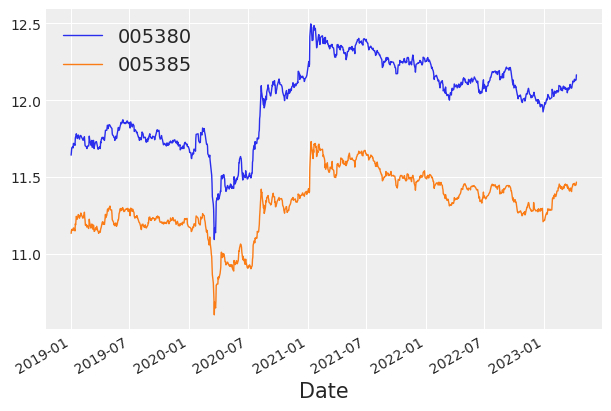

In [265]:
plt.figure(figsize = (6,4))
ax = plt.gca()
# plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,linewidth=1, fontsize=10)
orig_data[stock2_name].plot(ax=ax,linewidth=1, fontsize=10)
# plt.ylabel("Price")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

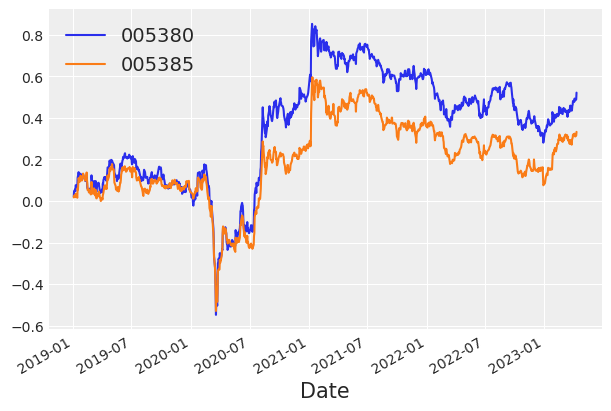

In [266]:
data[[stock1_name, stock2_name]].plot(figsize=(6,4), fontsize=10)

In [212]:
data.shape

(1051, 2)

In [267]:
with pm.Model() as model:
    
    stock1 = data1
    stock2 = data2
    
    #stock1 = pytensor.shared(data1)
    #stock2 = pytensor.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)    
    beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, shape=data1.shape[0], init_dist=pm.Normal.dist(0, 10))
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)

with model:
    #stock1.set_value(data1)
    #stock2.set_value(data2)
    idata = pm.sample(chains=2, cores=8, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [beta_sigma, beta, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [259]:
idata.posterior['beta'][0,0]

<xarray.DataArray 'beta' (beta_dim_0: 1050)>
array([1.15435514, 1.16015368, 1.16532863, ..., 1.07200058, 1.07235817,
       1.05931886])
Coordinates:
    chain       int32 0
    draw        int32 0
  * beta_dim_0  (beta_dim_0) int32 0 1 2 3 4 5 ... 1044 1045 1046 1047 1048 1049

In [255]:
idata.posterior['beta'][0,0]

<xarray.DataArray 'beta' (beta_dim_0: 1051)>
array([1.13364934, 1.12626485, 1.09413945, ..., 1.07751875, 1.06426117,
       1.08427927])
Coordinates:
    chain       int32 0
    draw        int32 0
  * beta_dim_0  (beta_dim_0) int32 0 1 2 3 4 5 ... 1045 1046 1047 1048 1049 1050

In [107]:
# with pm.Model() as model:
#     model.add_coord('dates', data.index[:250], mutable = True)
#     stock1 = pm.MutableData('stock1', data1[:250], dims='dates')
#     stock2 = pm.MutableData('stock2', data2[:250], dims='dates')
    
#     beta_sigma = pm.Exponential('beta_sigma', 50.)
#     beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, init_dist=pm.Normal.dist(0, 10), dims='dates')
    
#     stock2_regression = beta * stock1
#     sd = pm.HalfNormal('sd', sigma=.1)
#     likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)
    
#     idata = pm.sample(chains=2, cores=8, random_seed=0)
    
    
# with model:
#     for i in range(2):
#         pm.set_data({
#             'stock1': [data1[600]],
#             'stock2': [data2[600]]
#         }, coords={ 'dates': [600] })

#     #     idata.extend(pm.sample_posterior_predictive(idata))
# #         idata2 = pm.sample(chains=2, cores=8, random_seed=0)
#         idata3 = pm.sample_prior_predictive(samples=1000, random_seed=0)    

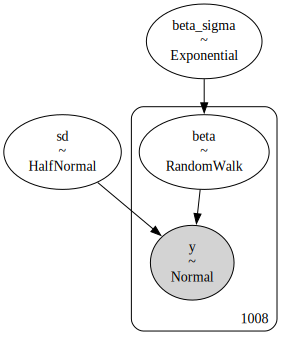

In [239]:
pm.model_to_graphviz(model)

In [268]:
# rolling_beta = idata.posterior['beta'].T.mean(axis=1)[:,0]#.mean(axis=1)
rolling_beta = idata.posterior['beta'].mean(dim=['draw','chain'])

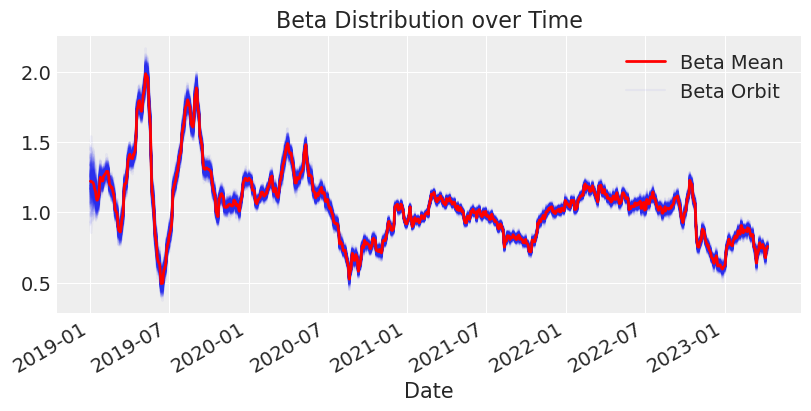

In [296]:
plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)

for orbit in idata.posterior['beta'].sel(draw=slice(0,300))[0]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
    

plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

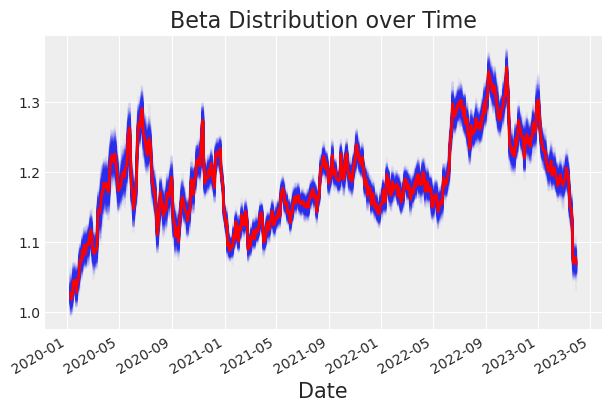

In [106]:
plt.figure(figsize = (6,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta[250:],index=orig_data.index[250:]).plot(ax=ax,color='r',zorder=1e6,linewidth=2, fontsize=10)

for orbit in idata.posterior['beta'].sel(draw=slice(0,300))[0]:
    pd.Series(orbit[250:],index=orig_data.index[250:]).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05, fontsize=10)
    

# plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

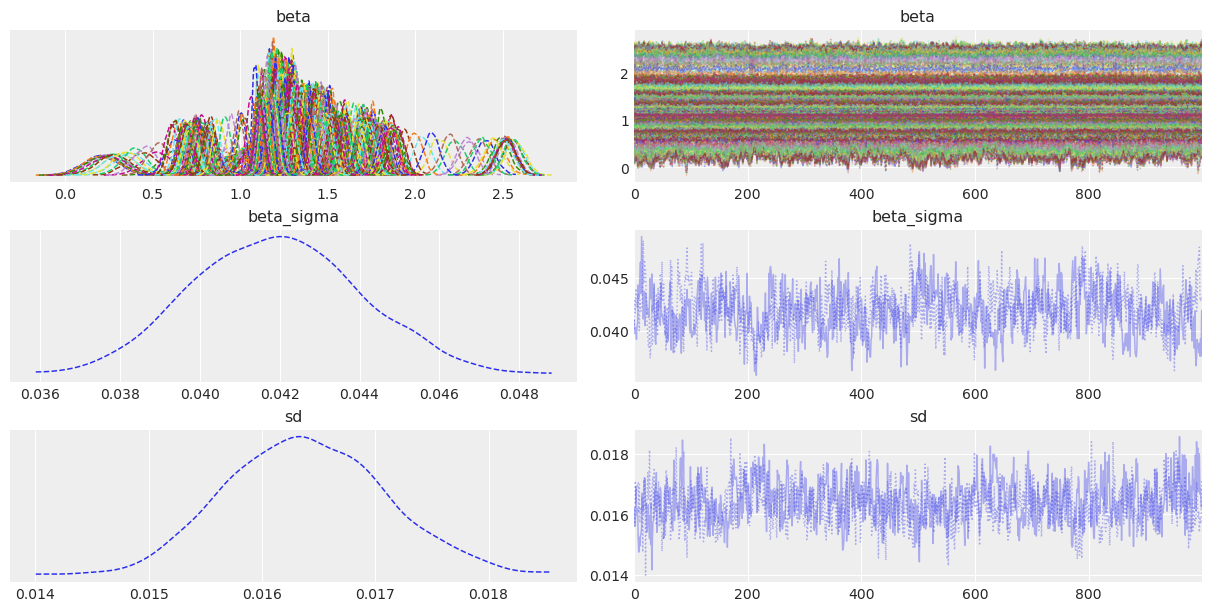

In [21]:
az.plot_trace(idata, combined=True);

In [272]:
def getStrategyPortfolioWeights(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()
            
            signal_spot[i] = smoothed_signal[i]

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max #np.sign(w0 / w_max)
                leverage.iloc[i,1] = w1 / w_max #np.sign(w1 / w_max)
                                
                trading = "short"
                trading_start = smoothed_signal[i]
                
#             elif smoothed_signal[i] < 0 and d_smoothed_signal[i] > 0:
#                 w0 = fixed_beta / (abs(fixed_beta)+1)
#                 w1 = -1 / (abs(fixed_beta)+1)
                
#                 w_max = max(abs(w0), abs(w1))
                
#                 leverage.iloc[i,0] = w0 / w_max
#                 leverage.iloc[i,1] = w1 / w_max
                                
#                 trading = "long"
#                 trading_start = smoothed_signal[i]                
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                
        elif trading=="long":
            # a failed trade
            if smoothed_signal[i] < trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] > 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [273]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * (0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)
            #cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * 0.0001#(0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    net_profit = int(values[-1] - start_cash)
    net_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / (net_profit + total_cost) * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (leverageDF.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = net_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))

    print(f'테스트 일수: {n_days}일')
    print(f'순손익 (투자금액대비%): {format(net_profit, ",")}원 ({net_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pd.Series(pnl)
    )

# 삼성전자

테스트 일수: 800일
순손익 (투자금액대비%): 19,028,510원 (19.029%)
총비용 (총손익대비%): 21,240,389원 (52.746%)
진입횟수: 92회
월평균 진입횟수: 2.30회
진입일수 (전체일수대비%): 93일 (11.62%)
평균보유일수: 1.01일
진입당 평균손익: 206,831원
최대수익: 2,823,888원
최대손실: -1,909,651원
수익진입의 평균수익: 743,432원
손실진입의 평균손실: -404,643원


<Axes: xlabel='Date'>

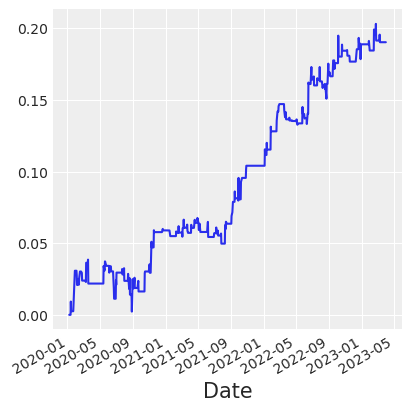

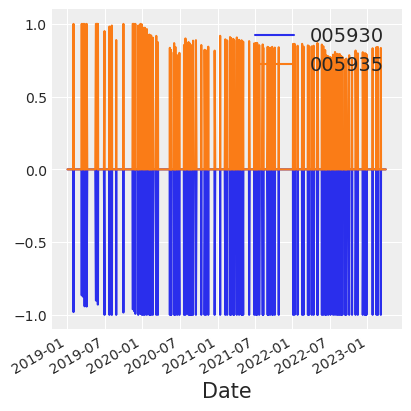

In [45]:
w0, signal0 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares0, cash0, returns0, values0, pnl_hist0, pnl0 = backtest(p_data[250:], p_open_data[250:], w0[250:], 1e8)
returns0.plot(figsize=(4,4), fontsize=10)
w0.plot(figsize=(4,4), fontsize=10)

In [30]:
w0.tail()

,005930,005935
Date,,
2023-04-03,0.0,0.0
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0


<Axes: >

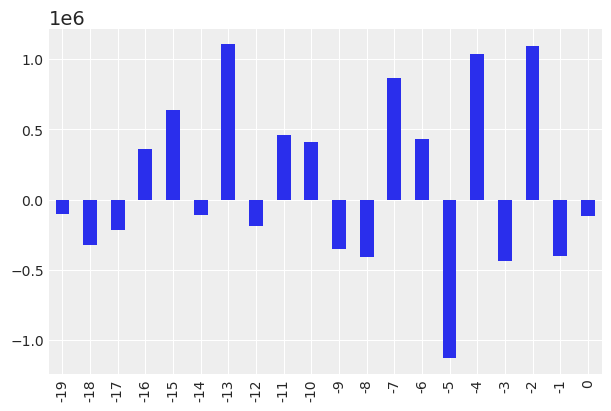

In [31]:
_pnl = pnl0.iloc[-20:]#.plot.bar()
_pnl.index = list(range(-19,1))
_pnl.plot.bar(figsize=(6,4), fontsize=10)

# LG전자

테스트 일수: 800일
순손익 (투자금액대비%): 35,273,125원 (35.273%)
총비용 (총손익대비%): 18,919,974원 (34.912%)
진입횟수: 82회
월평균 진입횟수: 2.05회
진입일수 (전체일수대비%): 121일 (15.12%)
평균보유일수: 1.48일
진입당 평균손익: 430,160원
최대수익: 3,166,148원
최대손실: -4,125,558원
수익진입의 평균수익: 1,237,962원
손실진입의 평균손실: -898,805원


<Axes: xlabel='Date'>

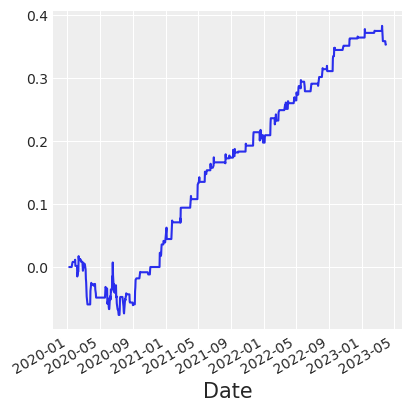

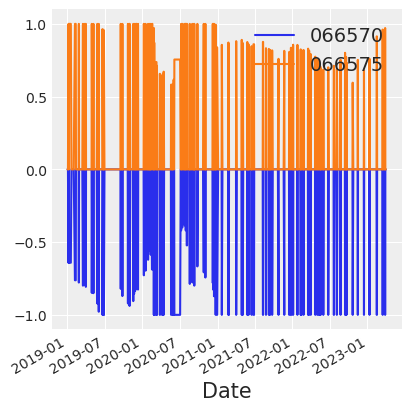

In [52]:
w1, signal1 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares1, cash1, returns1, values1, pnl_hist1, pnl1 = backtest(p_data[250:], p_open_data[250:], w1[250:], 1e8)
returns1.plot(figsize=(4,4), fontsize=10)
w1.plot(figsize=(4,4), fontsize=10)

In [198]:
w1.tail()

,066570,066575
Date,,
2023-04-04,0.0,0.000000
2023-04-05,-1.0,0.951415
2023-04-06,0.0,0.000000
2023-04-07,0.0,0.000000
2023-04-10,0.0,0.000000


# 삼성SDI

테스트 일수: 800일
순손익 (투자금액대비%): 82,267,123원 (82.267%)
총비용 (총손익대비%): 16,794,476원 (16.954%)
진입횟수: 79회
월평균 진입횟수: 1.98회
진입일수 (전체일수대비%): 94일 (11.75%)
평균보유일수: 1.19일
진입당 평균손익: 1,041,355원
최대수익: 11,341,820원
최대손실: -3,621,398원
수익진입의 평균수익: 1,866,315원
손실진입의 평균손실: -1,096,038원


<Axes: xlabel='Date'>

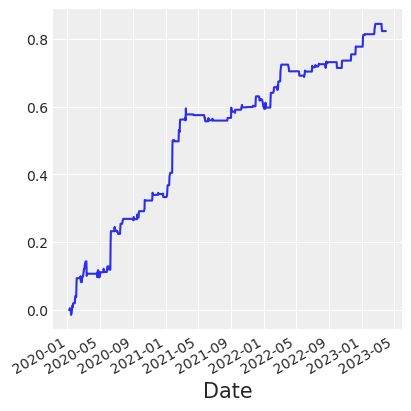

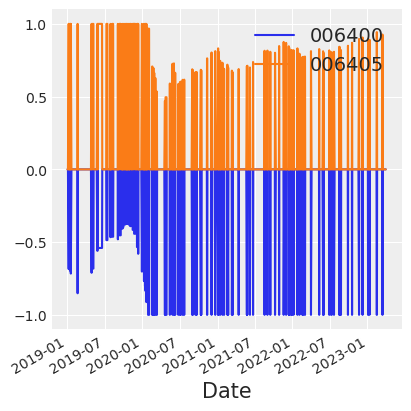

In [60]:
w2, signal2 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares2, cash2, returns2, values2, pnl_hist2, pnl2 = backtest(p_data[250:], p_open_data[250:], w2[250:], 1e8)
returns2.plot(figsize=(4,4), fontsize=10)
w2.plot(figsize=(4,4), fontsize=10)

In [206]:
w2.tail()

,006400,006405
Date,,
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0
2023-04-10,0.0,0.0


# LG화학

테스트 일수: 800일
순손익 (투자금액대비%): 86,071,636원 (86.072%)
총비용 (총손익대비%): 24,987,363원 (22.499%)
진입횟수: 96회
월평균 진입횟수: 2.40회
진입일수 (전체일수대비%): 134일 (16.75%)
평균보유일수: 1.40일
진입당 평균손익: 896,579원
최대수익: 23,673,852원
최대손실: -8,694,000원
수익진입의 평균수익: 2,198,131원
손실진입의 평균손실: -1,706,524원


<Axes: xlabel='Date'>

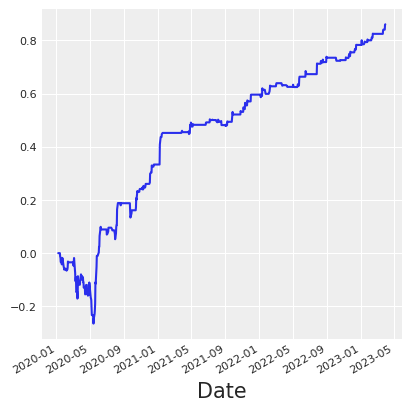

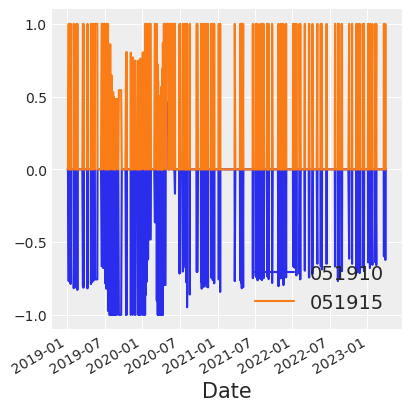

In [67]:
w3, signal3 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares3, cash3, returns3, values3, pnl_hist3, pnl3 = backtest(p_data[250:], p_open_data[250:], w3[250:], 1e8)
returns3.plot(figsize=(4,4), fontsize=8)
w3.plot(figsize=(4,4), fontsize=10)

In [68]:
w3.tail()

,051910,051915
Date,,
2023-03-27,0.000000,0.0
2023-03-28,0.000000,0.0
2023-03-29,-0.622834,1.0
2023-03-30,0.000000,0.0
2023-03-31,0.000000,0.0


# 현대차

테스트 일수: 807일
순손익 (투자금액대비%): 39,675,262원 (39.675%)
총비용 (총손익대비%): 26,125,837원 (39.704%)
진입횟수: 101회
월평균 진입횟수: 2.50회
진입일수 (전체일수대비%): 130일 (16.11%)
평균보유일수: 1.29일
진입당 평균손익: 392,824원
최대수익: 9,824,553원
최대손실: -4,021,175원
수익진입의 평균수익: 1,144,187원
손실진입의 평균손실: -852,856원


<Axes: xlabel='Date'>

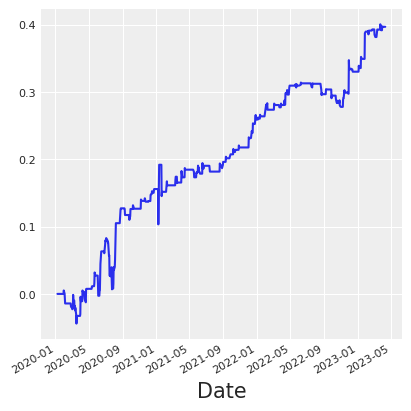

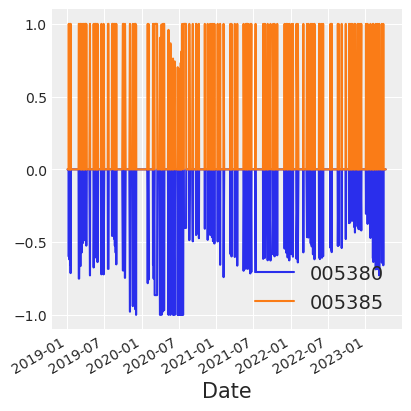

In [274]:
w4, signal4 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares4, cash4, returns4, values4, pnl_hist4, pnl4 = backtest(p_data[250:], p_open_data[250:], w4[250:], 1e8)
returns4.plot(figsize=(4,4), fontsize=8)
w4.plot(figsize=(4,4), fontsize=10)

In [275]:
w4.tail()

,005380,005385
Date,,
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0
2023-04-10,0.0,0.0
2023-04-11,0.0,0.0


In [286]:
notional = 10000000
(notional * w4.iloc[-1] / p_data.iloc[-1]).astype(int)

005380    -53
005385    106
Name: 2023-04-10 00:00:00, dtype: int32

In [285]:
16*1859000, 319*94000

(29744000, 29986000)

# 삼성SDI + LG화학 + 현대차

<Axes: xlabel='Date'>

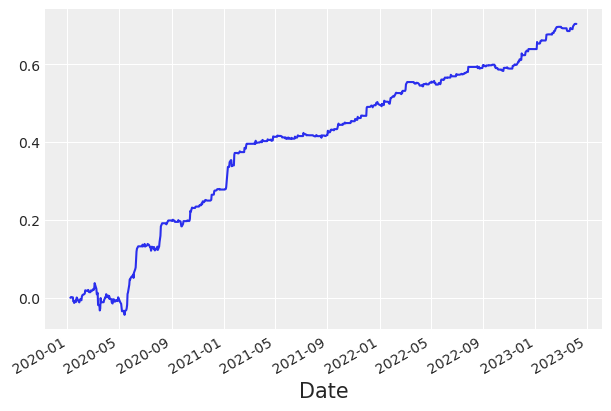

In [65]:
total_values = values2 + values3 + values4
((total_values / total_values.iloc[0]) - 1).plot(fontsize=10, figsize=(6,4))

<Axes: >

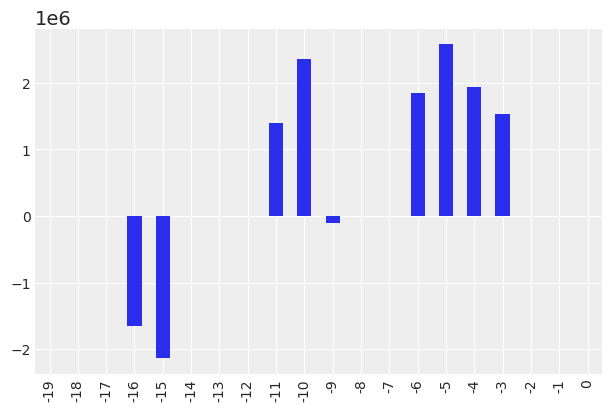

In [76]:
_pnl_total = (pnl_hist2 + pnl_hist3 + pnl_hist4).iloc[-20:]
_pnl_total.index = list(range(-19,1))
_pnl_total.plot.bar(figsize=(6,4), fontsize=10)

테스트 일수: 800일
순손익 (투자금액대비%): 188,864,731원 (188.865%)
총비용 (총손익대비%): 6,340,268원 (3.248%)
진입횟수: 170회
월평균 진입횟수: 4.25회
진입일수 (전체일수대비%): 173일 (21.62%)
평균보유일수: 1.02일
진입당 평균손익: 1,110,969원
최대수익: 7,070,381원
최대손실: -7,185,421원
수익진입의 평균수익: 1,558,476원
손실진입의 평균손실: -895,597원


<Axes: xlabel='Date'>

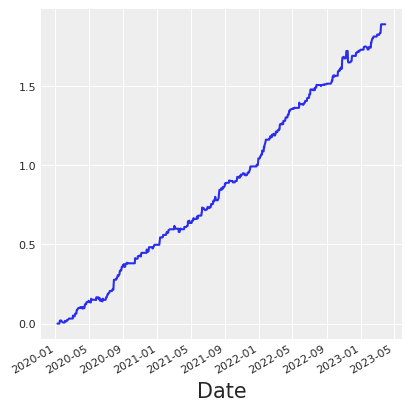

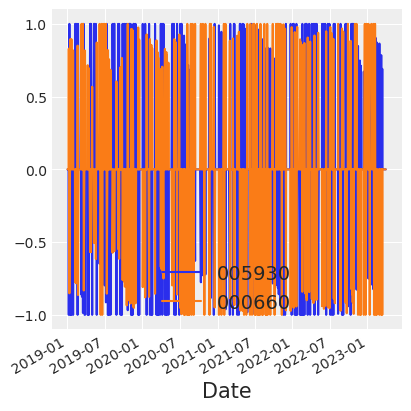

In [126]:
w5, signal5 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data[250:], p_open_data[250:], w5[250:], 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

In [128]:
w5.tail(20)

,005930,000660
Date,,
2023-03-06,0.000000,0.0
2023-03-07,0.000000,0.0
2023-03-08,0.000000,0.0
2023-03-09,0.785092,-1.0
2023-03-10,0.000000,0.0
2023-03-13,0.000000,0.0
2023-03-14,0.690835,-1.0
2023-03-15,0.000000,0.0
2023-03-16,0.000000,0.0


테스트 일수: 806일
순손익 (투자금액대비%): 188,534,821원 (188.535%)
총비용 (총손익대비%): 6,336,578원 (3.252%)
진입횟수: 170회
월평균 진입횟수: 4.22회
진입일수 (전체일수대비%): 174일 (21.59%)
평균보유일수: 1.02일
진입당 평균손익: 1,109,028원
최대수익: 7,070,381원
최대손실: -7,185,421원
수익진입의 평균수익: 1,563,333원
손실진입의 평균손실: -850,164원


<Axes: xlabel='Date'>

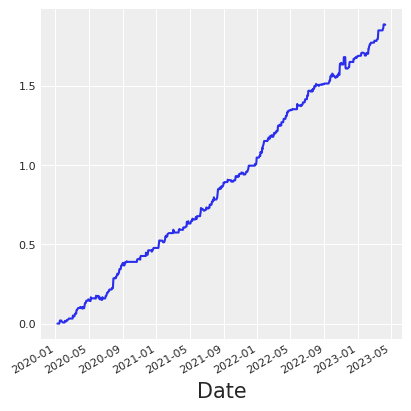

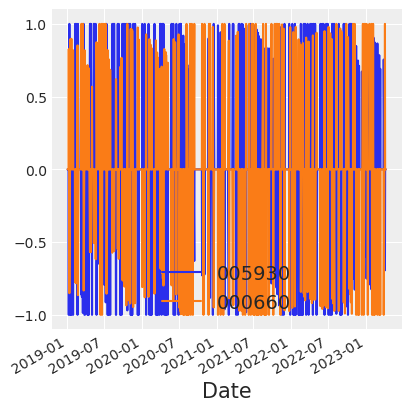

In [109]:
w5, signal5 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data[250:], p_open_data[250:], w5[250:], 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

In [111]:
w5.tail()

,005930,000660
Date,,
2023-04-04,0.000000,0.0
2023-04-05,0.000000,0.0
2023-04-06,-0.693815,1.0
2023-04-07,0.000000,0.0
2023-04-10,0.000000,0.0


테스트 일수: 804일
순손익 (투자금액대비%): 180,028,879원 (180.029%)
총비용 (총손익대비%): 6,221,220원 (3.340%)
진입횟수: 167회
월평균 진입횟수: 4.15회
진입일수 (전체일수대비%): 170일 (21.14%)
평균보유일수: 1.02일
진입당 평균손익: 1,078,017원
최대수익: 7,070,381원
최대손실: -7,185,634원
수익진입의 평균수익: 1,567,184원
손실진입의 평균손실: -835,491원


<Axes: xlabel='Date'>

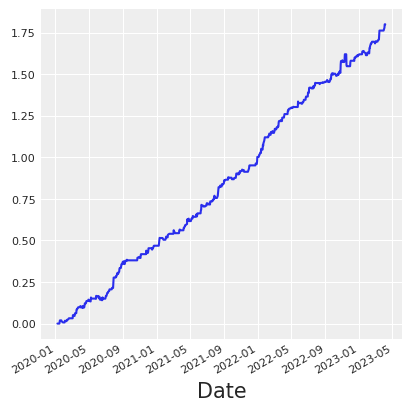

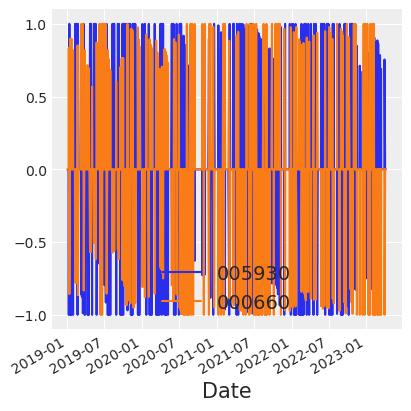

In [118]:
w5, signal5 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data[250:], p_open_data[250:], w5[250:], 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

In [119]:
w5.tail()

,005930,000660
Date,,
2023-03-31,0.754994,-1.0
2023-04-03,0.000000,0.0
2023-04-04,0.000000,0.0
2023-04-05,0.000000,0.0
2023-04-06,0.000000,0.0


테스트 일수: 760일
순손익 (투자금액대비%): 173,732,997원 (173.733%)
총비용 (총손익대비%): 5,934,302원 (3.303%)
진입횟수: 159회
월평균 진입횟수: 4.18회
진입일수 (전체일수대비%): 164일 (21.58%)
평균보유일수: 1.03일
진입당 평균손익: 1,092,660원
최대수익: 7,070,381원
최대손실: -7,185,421원
수익진입의 평균수익: 1,509,957원
손실진입의 평균손실: -859,693원


<Axes: xlabel='Date'>

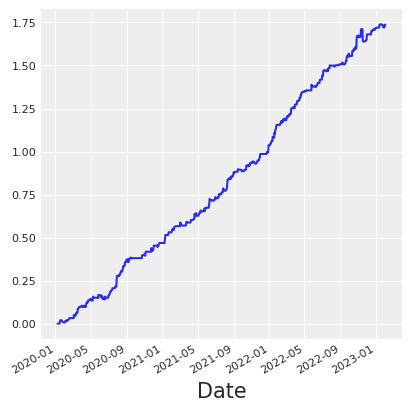

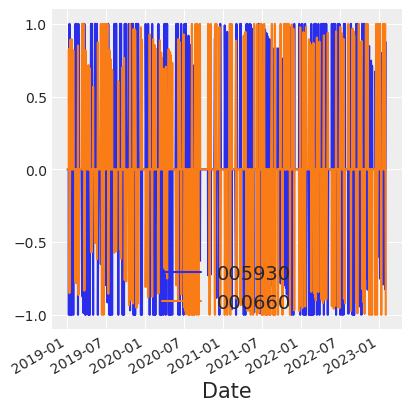

In [194]:
w5, signal5 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data[250:], p_open_data[250:], w5[250:], 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

In [186]:
w5.tail(10)

,005930,000660
Date,,
2023-01-18,0.000000,0.0
2023-01-19,0.000000,0.0
2023-01-20,-0.791186,1.0
2023-01-25,0.000000,0.0
2023-01-26,0.000000,0.0
2023-01-27,0.000000,0.0
2023-01-30,-0.824890,1.0
2023-01-31,0.000000,0.0
2023-02-01,0.000000,0.0
